In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

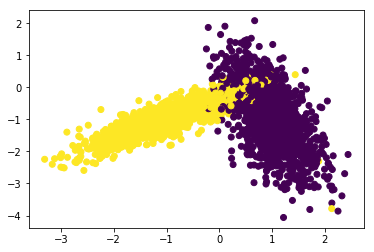

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [72]:
#Reference: https://stackoverflow.com/questions/61818704/building-a-custom-randomsearchcv-using-python
from tqdm import tqdm
from sklearn.metrics import accuracy_score
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    params = []  # To store the n_neighbors for each classifier 
    trainscores=[] #To store mean trainscores after k-fold validation
    testscores = [] #To store mean testscores after k-fold validation
    
    while len(params)<10: # Generating 10 random odd numbers between the parameter range
        k = np.random.randint(param_range[0],param_range[1]) # random integer between the range
        if k%2!=0 and k not in params:
            params.append(k)
  
    x_groups = np.array_split(x_train,folds) #Splitting the x_train into k folds using array split
    y_groups = np.array_split(y_train,folds)  #Splitting the y_train into k folds using array split
    params = sorted(params) 
    
    for k in tqdm(params): # For each n_neighbors in the list
        train_fold=[] #To store train score for each fold
        test_fold=[] #To store test score for each fold
        for i in range(folds): # For every fold in the current parameter
            X_test = x_groups[i] # For the current fold, storing the X_test
            validate_lst = x_groups.pop(i) # Removing temporarily the current fold set
            X_train = np.concatenate(np.array(x_groups),axis=0) # Except the X_test, concating other (k-1) folds array as X_train
            x_groups.insert(i,validate_lst) #Inserting the fold set back to its same position to preserve original order

            Y_test = y_groups[i] # For the current fold, storing the Y_test
            validate = y_groups.pop(i)  # Removing temporarily the current fold set
            Y_train = np.concatenate(np.array(y_groups),axis=0)# Except the X_test, concating other (k-1) folds array as Y_train
            y_groups.insert(i,validate) #Inserting the fold set back to its same position to preserve original order

            classifier.n_neighbors = k #Initializing the classifier with the number of neighbors
            classifier.fit(X_train,Y_train) # Fitting on the train set
            Y_train_predicted = classifier.predict(X_train) 
            train_fold.append(accuracy_score(Y_train,Y_train_predicted)) #Storing the train_accuracy for each fold

            Y_test_predicted = classifier.predict(X_test)
            test_fold.append(accuracy_score(Y_test,Y_test_predicted)) #Storing the test_accuracy for each fold

        trainscores.append(np.mean(np.array(train_fold))) #Mean of k fold train_accuracy and storing it for the current n_neighbor
        testscores.append(np.mean(np.array(test_fold))) #Mean of k fold test_accuracy and storing it for the current n_neighbor
    
    return trainscores,testscores,params
    

In [73]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


classifier = KNeighborsClassifier()

folds = 10
param_range=(1,30)
trainscores,testscores,params = RandomSearchCV(X_train, y_train, classifier, param_range, folds)

 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.46s/it]


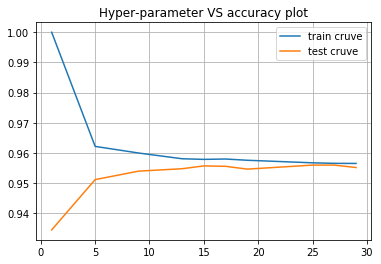

In [78]:
plt.plot(params,trainscores, label='train cruve')
plt.plot(params,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.grid()
plt.legend()
plt.show()

<p> The best K-value can be oberserved at <b>K=25</b> where there is minimal gap between test and train score </p>

In [75]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

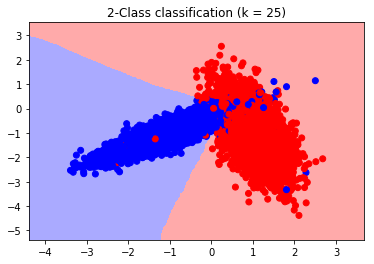

In [76]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 25)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)